<a href="https://colab.research.google.com/github/EdvardasDlugauskas/VT-atvir-duomen-analiz-/blob/master/vilniustransportOpenDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing all libraries**

In [0]:
from os import listdir, path

import numpy as np
import pandas as pd

from torch import nn, optim, autograd, FloatTensor, manual_seed, randperm
import torch.nn.functional as F

from sklearn import model_selection, preprocessing

# **Importing data from csv files (pd.read_csv)**

add csv files which names is shown in this section

Need to have a `VTDeepLearn/data/` folder with CSV data files in your Google Drive (get them from here: [Mega link](https://mega.nz/file/eAQB2aKQ#vJj5EapA8RUzwS_YRnKTnRsMXBNfb-eXOGIkRitoADI)).

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DATA_FOLDER_PATH = "/content/drive/My Drive/VTDeepLearn/data"
file_names = listdir(DATA_FOLDER_PATH)[:12]
dataframes = [pd.read_csv(path.join(DATA_FOLDER_PATH, file)) for file in file_names]


**Import stops names and Ids**

(Add folder to VTDeepLearn StopsInfo)

In [0]:
STOPS_DATA_FOLDER_PATH = "/content/drive/My Drive/VTDeepLearn/StopsInfo"
stops_file_names = listdir(STOPS_DATA_FOLDER_PATH)[:1]
stopsInfoList =  [pd.read_csv(path.join(STOPS_DATA_FOLDER_PATH, file)) for file in stops_file_names]
stopsInfoData = pd.concat(stopsInfoList).reset_index(drop=True)
print(stopsInfoData)

      id                    name
0      1                „Sparta“
1      2             Naujininkai
2      3   Dariaus ir Girėno st.
3      4                  Stotis
4      5               Prūsų st.
..   ...                     ...
659  660      Stepono Kairio st.
660  661              Metropolis
661  662            Vokiečių st.
662  663          Balsių mokykla
663  664  Žaliojo Visalaukio st.

[664 rows x 2 columns]


In [0]:
all_data = pd.concat(dataframes).reset_index(drop=True)
# TODO: all_data.max for normalization
all_data['IsHoliday'] = all_data['IsHoliday'].replace({False: 0, True: 1})


Replace all stops names with ids

In [0]:
for index, stopInfo in stopsInfoData.iterrows() :
  all_data = all_data.replace(to_replace = stopInfo['name'], 
                 value = stopInfo['id']) 

print(all_data['EndStop'])

0        172
1          5
2        172
3        172
4        172
        ... 
90757    528
90758    402
90759    528
90760    312
90761    348
Name: EndStop, Length: 90762, dtype: int64


Classify according to bus type



In [0]:
busDummy = pd.get_dummies(all_data['TransportType'])
all_data = pd.concat([all_data,busDummy],axis=1)
print(busDummy)

       BUS  EXP_BUS  TROL
0        1        0     0
1        1        0     0
2        1        0     0
3        1        0     0
4        1        0     0
...    ...      ...   ...
90757    0        0     1
90758    0        0     1
90759    0        0     1
90760    0        0     1
90761    0        0     1

[90762 rows x 3 columns]


classify according to bus number

In [0]:
busNumberDummy = pd.get_dummies(all_data['Number'])
all_data = pd.concat([all_data,busNumberDummy],axis=1)
print(busNumberDummy)

[1, 1]

       1  10  101N  102N  103N  104N  105N  11  ...  74  75  76  78  8  82  87  9
0      1   0     0     0     0     0     0   0  ...   0   0   0   0  0   0   0  0
1      1   0     0     0     0     0     0   0  ...   0   0   0   0  0   0   0  0
2      1   0     0     0     0     0     0   0  ...   0   0   0   0  0   0   0  0
3      1   0     0     0     0     0     0   0  ...   0   0   0   0  0   0   0  0
4      1   0     0     0     0     0     0   0  ...   0   0   0   0  0   0   0  0
...   ..  ..   ...   ...   ...   ...   ...  ..  ...  ..  ..  ..  .. ..  ..  .. ..
90757  0   0     0     0     0     0     0   0  ...   0   0   0   0  0   0   0  1
90758  0   0     0     0     0     0     0   0  ...   0   0   0   0  0   0   0  1
90759  0   0     0     0     0     0     0   0  ...   0   0   0   0  0   0   0  1
90760  0   0     0     0     0     0     0   0  ...   0   0   0   0  0   0   0  1
90761  0   0     0     0     0     0     0   0  ...   0   0   0   0  0   0   0  1

[90762 rows x 8

In [0]:
print(all_data)

      TransportType Number  StartStop  EndStop  ...  IsHoliday  BUS  EXP_BUS  TROL
0               BUS      1          8      172  ...          0    1        0     0
1               BUS      1          9        5  ...          0    1        0     0
2               BUS      1          8      172  ...          0    1        0     0
3               BUS      1          8      172  ...          0    1        0     0
4               BUS      1          5      172  ...          0    1        0     0
...             ...    ...        ...      ...  ...        ...  ...      ...   ...
90757          TROL      9        309      528  ...          0    0        0     1
90758          TROL      9        312      402  ...          0    0        0     1
90759          TROL      9        349      528  ...          0    0        0     1
90760          TROL      9        537      312  ...          0    0        0     1
90761          TROL      9         82      348  ...          0    0        0     1

[90

In [0]:
test_data = all_data[['ScheduledDeparture', 'ActualDeparture', 'ScheduledArrival', 'ActualArrival', 'IsHoliday']]
for column in test_data.drop(columns=['IsHoliday']):
    test_data.loc[:,column] = test_data.loc[:,column] / 1640

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
train_x_np, test_x_np, train_y_np, test_y_np = model_selection.train_test_split(test_data.drop(columns=['ActualArrival']).to_numpy(), test_data['ActualArrival'].to_numpy().reshape(-1, 1))

train_x, test_x = map(lambda x: autograd.Variable(FloatTensor(x), requires_grad=True), [train_x_np, test_x_np])
train_y, test_y = map(lambda x: autograd.Variable(FloatTensor(x)), [train_y_np, test_y_np])

**Alernative Test methods:**

Trying predict according to bus latency 


In [0]:
new_test_data = all_data;
print(new_test_data);
saveActualArrival = new_test_data['ActualArrival'] / 1440
saveScheduledArrival = new_test_data['ScheduledDeparture'] / 1440
new_test_data = new_test_data.drop(columns=['TransportType'])
new_test_data = new_test_data.drop(columns=['Number']) #later try classify
new_test_data['StartStop'] = new_test_data['StartStop'] / 1440
new_test_data['EndStop'] = new_test_data['EndStop'] / 1440
new_test_data['ScheduledDeparture'] = (new_test_data['ScheduledDeparture'] - new_test_data['ScheduledDeparture'] % 30) / 1440
new_test_data['ActualDeparture'] = (new_test_data['ActualDeparture'] - new_test_data['ActualDeparture'] % 30) / 1440
new_test_data['ScheduledArrival'] = (new_test_data['ScheduledArrival'] - new_test_data['ScheduledArrival'] % 30) / 1440
new_test_data['ActualArrival'] = (new_test_data['ActualArrival'] - new_test_data['ActualArrival'] % 30) / 1440


1 -> 59
29 -> 31

0 -> 30


1440 -> 48 classes

      TransportType Number  StartStop  EndStop  ...  8  82  87  9
0               BUS      1          8      172  ...  0   0   0  0
1               BUS      1          9        5  ...  0   0   0  0
2               BUS      1          8      172  ...  0   0   0  0
3               BUS      1          8      172  ...  0   0   0  0
4               BUS      1          5      172  ...  0   0   0  0
...             ...    ...        ...      ...  ... ..  ..  .. ..
90757          TROL      9        309      528  ...  0   0   0  1
90758          TROL      9        312      402  ...  0   0   0  1
90759          TROL      9        349      528  ...  0   0   0  1
90760          TROL      9        537      312  ...  0   0   0  1
90761          TROL      9         82      348  ...  0   0   0  1

[90762 rows x 96 columns]


In [0]:


somey = saveActualArrival.to_numpy() - saveScheduledArrival.to_numpy()


train_x_np, test_x_np, train_y_np, test_y_np = model_selection.train_test_split(new_test_data.drop(columns=['ActualArrival']).to_numpy(), somey.reshape(-1, 1))

train_x, test_x = map(lambda x: autograd.Variable(FloatTensor(x), requires_grad=True), [train_x_np, test_x_np])
train_y, test_y = map(lambda x: autograd.Variable(FloatTensor(x)), [train_y_np, test_y_np])

In [0]:
print(new_test_data.drop(columns=['ActualArrival']).to_numpy())

[[0.00555556 0.11944444 0.20833333 ... 0.         0.         0.        ]
 [0.00625    0.00347222 0.22916667 ... 0.         0.         0.        ]
 [0.00555556 0.11944444 0.25       ... 0.         0.         0.        ]
 ...
 [0.24236111 0.36666667 0.70833333 ... 0.         0.         1.        ]
 [0.37291667 0.21666667 0.75       ... 0.         0.         1.        ]
 [0.05694444 0.24166667 0.77083333 ... 0.         0.         1.        ]]


end of test methods

In [0]:
manual_seed(3)

net = nn.Sequential(
        nn.Linear(93, 20),
        nn.LeakyReLU(),
        nn.Linear(20, 10),
        nn.LeakyReLU(),
        nn.Linear(10, 1),
    )

optimizer = optim.SGD(net.parameters(), lr=0.2)
loss_func = nn.MSELoss()
batch_size = 500_000

val_loss_history = []
train_loss_history = []

for epoch in range(5000):
    net.train()

    data_len = train_x.size()[0];
    permutation = randperm(data_len)

    epoch_losses = []
    for batch_i in range(0, data_len, batch_size):
        

        indices = permutation[batch_i:batch_i+batch_size]
        batch_x, batch_y = train_x[indices], train_y[indices]

        outputs = net(batch_x)
        loss = loss_func(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    train_loss_history.append(np.mean(epoch_losses))

    net.eval()
    y_hat = net(test_x) 

    val_loss = loss_func(y_hat, test_y).item()
    val_loss_history.append(val_loss)

    if not epoch % 10:
        print(f"Epoch: {epoch}, loss: {val_loss}")

    


print('Finished Training')

Epoch: 0, loss: 0.0066184233874082565
Epoch: 10, loss: 0.0002354859170736745
Epoch: 20, loss: 0.00022707346943207085
Epoch: 30, loss: 0.00021927400666754693
Epoch: 40, loss: 0.00021200104674790055
Epoch: 50, loss: 0.00020519233657978475
Epoch: 60, loss: 0.00019881232583429664
Epoch: 70, loss: 0.00019281345885246992
Epoch: 80, loss: 0.00018717160855885595
Epoch: 90, loss: 0.0001818692107917741
Epoch: 100, loss: 0.00017688154184725136
Epoch: 110, loss: 0.00017220476001966745
Epoch: 120, loss: 0.00016782064631115645
Epoch: 130, loss: 0.0001637070527067408
Epoch: 140, loss: 0.0001598482340341434
Epoch: 150, loss: 0.00015621971397195011
Epoch: 160, loss: 0.00015280245861504227
Epoch: 170, loss: 0.00014957814710214734
Epoch: 180, loss: 0.0001465297391405329
Epoch: 190, loss: 0.00014365205424837768
Epoch: 200, loss: 0.00014093196659814566
Epoch: 210, loss: 0.0001383501512464136
Epoch: 220, loss: 0.00013588905858341604
Epoch: 230, loss: 0.00013353623216971755
Epoch: 240, loss: 0.00013127099373

# Plot

In [0]:
from matplotlib import pyplot as plt

## Train loss vs test loss

([<matplotlib.lines.Line2D at 0x7fa789470160>],
 [<matplotlib.lines.Line2D at 0x7fa78bece400>])

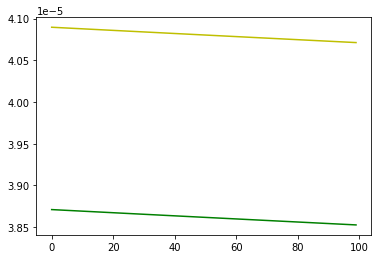

In [0]:
plt.plot(train_loss_history[-100:], c="y"), plt.plot(val_loss_history[-100:], c="g")

## Final model

In [0]:
y_hat = net(test_x)

(<matplotlib.collections.PathCollection at 0x7fa78949f400>,
 <matplotlib.collections.PathCollection at 0x7fa78d4fd1d0>)

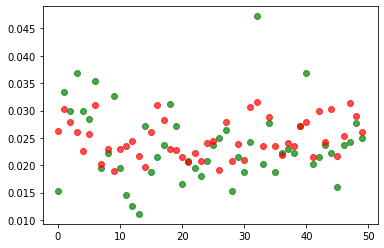

In [0]:
count = 50
plt.scatter(range(count),test_y.numpy()[:count], alpha=0.7, c='g'), plt.scatter(range(count), y_hat.detach().numpy()[:count], alpha=0.7, c='r')

In [0]:
print(test_x.detach().numpy()[:5] * 1640)
print(test_y.detach().numpy()[:5] * 1640)
print(y_hat.detach().numpy()[:5] * 1640)

[[ 492.00003   243.72223   615.        615.        649.1667   1640.
  1640.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.       1640.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.     

print for test methods:

In [0]:
print(test_x.detach().numpy()[:10] * 1440)
print(test_y.detach().numpy()[:10] * 1440)
print(y_hat.detach().numpy()[:10] * 1440)

[[4.3200003e+02 2.1400000e+02 5.4000000e+02 5.4000000e+02 5.7000000e+02
  1.4400000e+03 1.4400000e+03 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000

# Resources & links

https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379

https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb#scrollTo=RBCa4nG5wJAv

Problem: model guessing the same number for all inputs (mean/baseline)

Solution: normalize input